In [2]:
from __future__ import division

%matplotlib inline

import zipfile
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
# national_counties = gpd.read_file('./tl_2014_us_county/tl_2014_us_county.shp')
# tx_counties = national_counties.loc[national_counties.STATEFP == '48']
# tx_counties.to_file('texas_counties.shp')

In [4]:
tx = gpd.read_file('./tx_counties/texas_counties.shp')

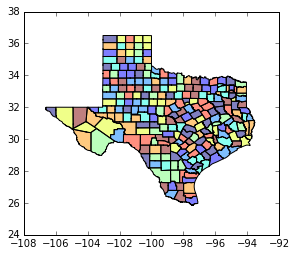

In [5]:
tx.plot()

In [6]:
county_fips_list = ['021', '055', '209', '453', '491']

austin_counties = tx.loc[tx.COUNTYFP.isin(county_fips_list)]
print len(austin_counties)

5


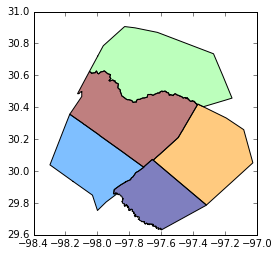

In [7]:
austin_counties_plot = austin_counties.plot()

In [8]:
pumas = gpd.read_file('./tl_2014_48_puma10/tl_2014_48_puma10.shp')

In [9]:
austin_pumas = gpd.sjoin(pumas, austin_counties)

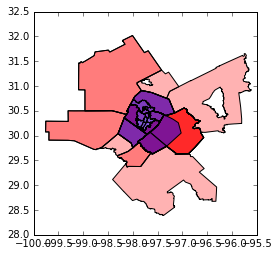

In [10]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

austin_pumas.plot(ax=ax, 
                  color='red',
                  alpha=.3)


austin_counties.plot(ax=ax,
                     color='blue')

plt.show()

In [11]:
# Looks like they nest but intersect is the wrong join

austin_pumas = gpd.sjoin(pumas, austin_counties, op='within')

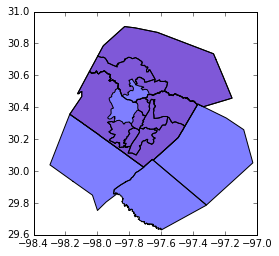

In [12]:
# BETTER!

fig, ax = plt.subplots()
ax.set_aspect('equal')

austin_pumas.plot(ax=ax, 
                  color='red',
                  alpha=.3)


austin_counties.plot(ax=ax,
                     color='blue')

plt.show()

In [13]:
len(austin_pumas)

11

In [14]:
list_austin_pumas = austin_pumas.PUMACE10.astype('int').tolist()
print list_austin_pumas

[5202, 5204, 5201, 5301, 5304, 5303, 5302, 5307, 5306, 5308, 5309]


In [15]:
with zipfile.ZipFile('csv_ptx.zip') as archive:
    
    csv = archive.open('ss14ptx.csv')
    pums = pd.read_csv(csv)

In [16]:
pums.head()

,RT,SERIALNO,SPORDER,PUMA,ST,ADJINC,PWGTP,AGEP,CIT,CITWP,...,pwgtp71,pwgtp72,pwgtp73,pwgtp74,pwgtp75,pwgtp76,pwgtp77,pwgtp78,pwgtp79,pwgtp80
0,P,3,1,3602,48,1008425,90,69,1,,...,101,30,31,25,95,79,76,87,91,25
1,P,3,2,3602,48,1008425,82,53,1,,...,81,27,24,21,98,67,69,93,101,21
2,P,3,3,3602,48,1008425,128,11,1,,...,113,42,47,35,128,108,100,116,127,27
3,P,5,1,6603,48,1008425,112,68,1,,...,114,99,140,31,110,111,109,178,100,205
4,P,5,2,6603,48,1008425,97,64,1,,...,103,95,100,25,92,90,91,142,101,211


In [17]:
# Recode race/ethnicity

pums.loc[pums.HISP != 1, 'race_eth'] = 'Hispanic/Latino'
pums.loc[(pums.RAC1P == 1) & (pums.HISP == 1), 'race_eth'] = 'White Alone'
pums.loc[(pums.RAC1P == 2) & (pums.HISP == 1), 'race_eth'] = 'Black Alone'
pums.loc[(pums.RAC1P == 6) & (pums.HISP == 1), 'race_eth'] = 'Asian Alone'
pums.loc[pums.race_eth.isnull(), 'race_eth'] = 'Multiracial/Other'

In [18]:
# Dummy variables

pums['black'] = 0
pums.loc[pums.race_eth == 'Black Alone', 'black'] = 1

pums['hisp_dummy'] = 0
pums.loc[pums.HISP != 1, 'hisp_dummy'] = 1

In [19]:
austin_pums = pums.loc[pums.PUMA.isin(list_austin_pumas)]
print len(austin_pums), len(pums)

13286 254883


In [20]:
austin_workers = austin_pums.loc[austin_pums.COW.isin(range(1,9))]
print len(austin_workers)

8398


In [21]:
# Filter for industries

industries = ['5121', '515']

# 5121 MOTION PICTURE AND VIDEO INDUSTRIES
# 515 BROADCASTING, EXCEPT INTERNET

df = pums.loc[pums.NAICSP.isin(industries)]
len(df)

654

In [22]:
df.NAICSP.value_counts()

515     364
5121    290
Name: NAICSP, dtype: int64

In [23]:
# Check worker status

df.COW.value_counts(sort=False)

# All looks good

1.0    568
2.0     30
3.0      2
4.0      4
5.0      4
6.0     28
7.0     15
8.0      3
Name: COW, dtype: int64

In [24]:
# Age

print df.AGEP.describe()

count    654.000000
mean      38.068807
std       15.729232
min       16.000000
25%       24.000000
50%       35.000000
75%       50.000000
max       92.000000
Name: AGEP, dtype: float64


In [25]:
austin_workers.AGEP.describe()

count    8398.000000
mean       41.658847
std        14.786978
min        16.000000
25%        29.000000
50%        40.000000
75%        53.000000
max        92.000000
Name: AGEP, dtype: float64

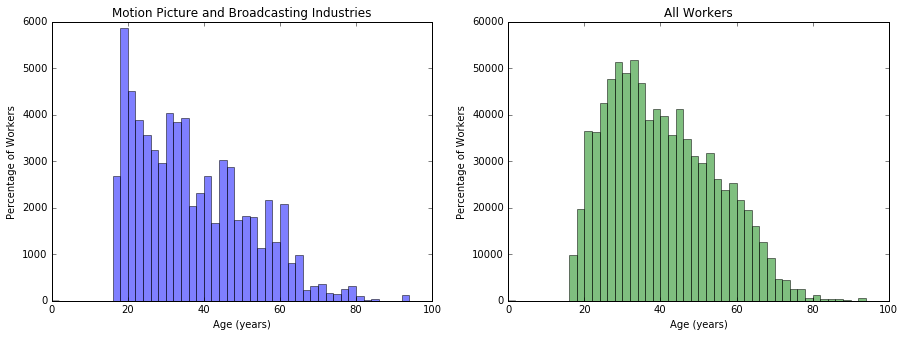

In [48]:
fig = plt.figure(figsize=[15,5])

colors = ['blue', 'green']
titles = ['Motion Picture and Broadcasting Industries', 'All Workers']
weight_list = [df.PWGTP, austin_workers.PWGTP]

agebins = [i for i in range(0,100,2)]

for i, var in enumerate([df.AGEP, austin_workers.AGEP]):
    ax = fig.add_subplot(1, 2, i+1)
    ax.hist(var,
            bins=agebins,
            alpha=0.5,
#             normed=True,
            color=colors[i],
            weights=weight_list[i])
#     ax.set_ylim([0, 0.05])
    ax.set_title(titles[i])
    ax.set_xlabel('Age (years)')
    ax.set_ylabel('Percentage of Workers')

plt.show()

In [27]:
# Comparison Table

def comparison_table(df, austin_workers, variable):
        
    counts_industry = df.groupby(variable).agg('sum').PWGTP
    counts = pd.DataFrame(counts_industry)

    counts_austin = pd.DataFrame(austin_workers.groupby(variable).agg('sum').PWGTP)
    counts = counts.merge(counts_austin, left_index=True, right_index=True)
    counts.columns = ['industries', 'austin']
    
    counts['industries_pct'] = counts.apply(lambda row: row.industries / counts.industries.sum(), axis=1)
    counts['austin_pct'] = counts.apply(lambda row: row.austin / counts.austin.sum(), axis=1)
    
    return counts

In [28]:
df.groupby('race_eth').agg('sum').PWGTP

race_eth
Asian Alone           2735
Black Alone           8156
Hispanic/Latino      20355
Multiracial/Other     1228
White Alone          36544
Name: PWGTP, dtype: int64

In [45]:
comparison_table(df, austin_workers, 'race_eth')

,industries,austin,industries_pct,austin_pct
race_eth,,,,
Asian Alone,2735,47233,0.039627,0.053222
Black Alone,8156,66791,0.118172,0.075260
Hispanic/Latino,20355,262677,0.294923,0.295985
Multiracial/Other,1228,18646,0.017792,0.021010
White Alone,36544,492119,0.529485,0.554522


In [30]:
black_comp = comparison_table(df, austin_workers, 'black')
black_comp

,industries,austin,industries_pct,austin_pct
black,,,,
0,60862,820675,0.881828,0.92474
1,8156,66791,0.118172,0.07526


In [31]:
black_np_array = black_comp.iloc[:,:-2].as_matrix()
stats.chi2_contingency(black_np_array)

(1632.2657017207396, 0.0, 1, array([[  63609.97221699,  817927.02778301],
        [   5408.02778301,   69538.97221699]]))

In [32]:
hisp_comp = comparison_table(df, austin_workers, 'hisp_dummy')
hisp_comp

,industries,austin,industries_pct,austin_pct
hisp_dummy,,,,
0,48663,624789,0.705077,0.704015
1,20355,262677,0.294923,0.295985


In [33]:
hisp_np_array = hisp_comp.iloc[:,:-2].as_matrix()
stats.chi2_contingency(hisp_np_array)

(0.34181081869992824,
 0.55878584336263137,
 1,
 array([[  48594.96879822,  624857.03120178],
        [  20423.03120178,  262608.96879822]]))

In [34]:
# Foreign born

comparison_table(df, austin_workers, 'NATIVITY')

,industries,austin,industries_pct,austin_pct
NATIVITY,,,,
1,61076,726339,0.884929,0.818441
2,7942,161127,0.115071,0.181559


In [35]:
# Income

adj = 1.008425

df['income'] = df.PINCP.astype(int).clip(lower=0) * adj
austin_workers['income'] = austin_workers.PINCP.astype(int).clip(lower=0) * adj

/home/paul/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/paul/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [36]:
df.ADJINC.value_counts()

1008425    654
Name: ADJINC, dtype: int64

In [37]:
df.income.describe()

count       654.000000
mean      38070.362819
std       51424.024534
min           0.000000
25%        6051.558425
50%       26723.262500
75%       47395.975000
max      677661.600000
Name: income, dtype: float64

In [38]:
austin_workers.income.describe()

count    8.398000e+03
mean     5.166268e+04
std      6.833314e+04
min      0.000000e+00
25%      1.492469e+04
50%      3.529488e+04
75%      6.232066e+04
max      1.005400e+06
Name: income, dtype: float64

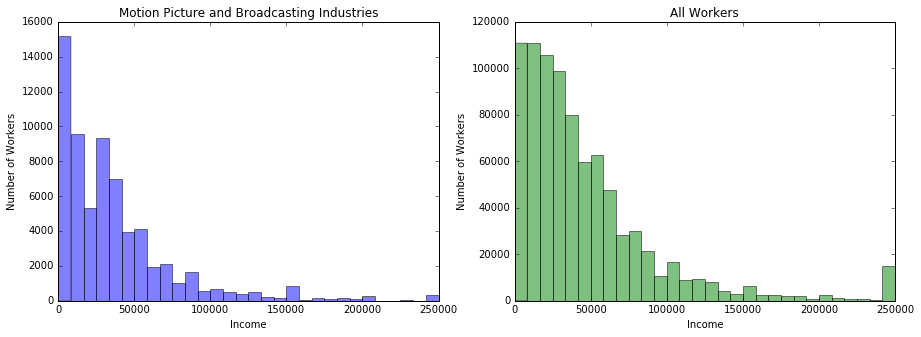

In [39]:
fig = plt.figure(figsize=[15,5])

colors = ['blue', 'green']
titles = ['Motion Picture and Broadcasting Industries', 'All Workers']
incomes = [df[df.income > 0].income.clip(upper=250000),
          austin_workers[austin_workers.income > 0].income.clip(upper=250000)]
weight_list = [df[df.income > 0].PWGTP,
          austin_workers[austin_workers.income > 0].PWGTP]

# agebins = [i for i in range(0,100,2)]

for i, var in enumerate(incomes):
    ax = fig.add_subplot(1, 2, i+1)
    ax.hist(var,
            bins=30,
            alpha=0.5,
#             normed=True,
            color=colors[i],
           weights=weight_list[i])
#     ax.set_ylim([0, 0.01])
    ax.set_title(titles[i])
    ax.set_xlabel('Income')
    ax.set_ylabel('Number of Workers')

plt.show()

In [42]:
income_df = pd.DataFrame()

cols = ['industries', 'austin']

for race in pums.race_eth.unique():
    
    a = df[df.race_eth == race].income.clip(upper=250000)
    b = austin_workers[austin_workers.race_eth == race].income.clip(upper=250000)
#     ttest = stats.ttest_ind(a, b)
#     pval = ttest[1]
#     sig = pval < 0.05
    
    aw =(a * df[df.race_eth == race].PWGTP)
    income_df.loc[race, 'industries'] =  aw.sum() / df[df.race_eth == race].PWGTP.sum()
         
    bw = (b * austin_workers[austin_workers.race_eth == race].PWGTP)
    income_df.loc[race, 'austin'] = (bw.sum() / 
                                    austin_workers[austin_workers.race_eth == race].PWGTP.sum())
#     income_df.loc[race, 'p-value'] = pval
#     income_df.loc[race, 'sig95'] = sig

In [43]:
income_df

,industries,austin
White Alone,40908.660420,53673.452790
Hispanic/Latino,26820.926244,31176.613730
Black Alone,27198.102582,33855.248160
Multiracial/Other,35084.280056,29548.080717
Asian Alone,43117.356405,47327.678992
